In [4]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import casadi as cas
plt.style.use('seaborn')

/var/folders/lh/93lccf9x56l539tw7z9d404r0000gn/T/ipykernel_4999/418906186.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [5]:
# Model
dt = 0.01
n = 3


X = cas.SX.sym('X', n)
nu = cas.SX.sym('nu', 2)
U = cas.SX.sym('U', 2)

x = X[0]
y = X[1]
delta = X[2]

f1 = X + cas.vertcat(cas.cos(delta) * (U[0] + nu[0]),
            cas.sin(delta) * (U[0] + nu[0]),
            U[1] + nu[1]) * dt

h1 = cas.vertcat(x, # GPS
                y, # GPS
            )

A1 = cas.jacobian(f1, X)
G1 = cas.jacobian(f1, nu)
H1 = cas.jacobian(h1, X)
A_fun1= cas.Function('A_fun', [X, U, nu], [A1])
G_fun1 = cas.Function('G_fun', [X, U], [G1])
H_fun1 = cas.Function('H_fun', [X], [H1])
f_fun1 = cas.Function('F_fun', [X, U, nu], [f1])
h_fun1 = cas.Function('h_fun', [X], [h1])

In [6]:
N = 10000

x0 = np.zeros(n)
x_hat = np.zeros((n, N))
x_true = np.zeros((n, N))

P = np.zeros((n, n, N))
P[:,:,0] = np.eye(n) * 1e-1
x_hat[:,0] = x0
x_true[:,0] = x0

u1 = np.array([1, 0.001])


sigma_eps_x = 1e-3
sigma_u = 1

Q = np.eye(2) * sigma_u**2
R = np.eye(2)*sigma_eps_x**2

nu = np.random.multivariate_normal([0, 0], Q, N).T
eps = np.random.multivariate_normal([0, 0], R, N).T


for i in range(N-1):
    # Compute ground truth
    x_true[:,i+1] = f_fun1(x_true[:,i], u1, 0*nu[:,i]).full().flatten()

    
    A = A_fun1(x_hat[:,i], u1, 0*nu[:,i]).full()
    G = G_fun1(x_hat[:,i], u1).full()
    

    
    # Prediction step
    x_hat[:,i+1] = f_fun1(x_hat[:,i], u1, nu[:,i]).full().flatten()
    P[:,:, i+1] = A @ P[:,:,i] @ A.T + G @ Q @ G.T

    # Update step
    z = x_true[:2,i] + eps[:,i]
    H = H_fun1(x_hat[:,i]).full()

    s = H @ P[:,:,i+1] @ H.T + R
    w = P[:,:,i+1] @ H.T @ np.linalg.inv(s)
    x_hat[:,i+1] = x_hat[:,i+1] + (w @ (z.T - h_fun1(x_hat[:,i+1]).full().flatten()))
    P[:,:,i+1] =  (np.eye(3) - w @ H) @ P[:,:,i+1]


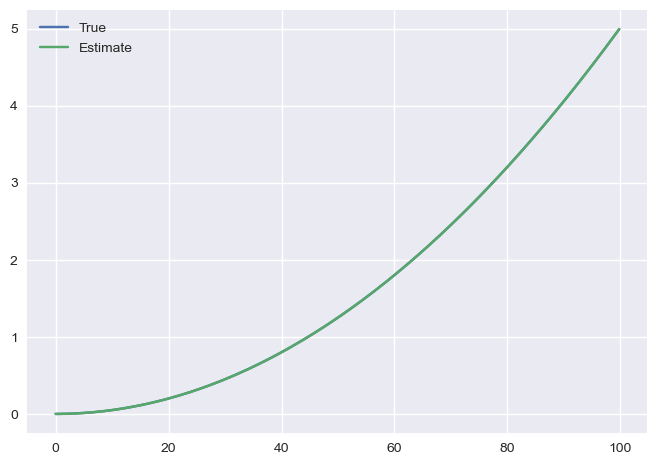

In [7]:
plt.plot(x_true[0,:], x_true[1,:])
plt.plot(x_hat[0,:], x_hat[1,:])
plt.legend(['True', 'Estimate'])

In [13]:
# ADD The other vehicle
X = cas.SX.sym('X', 2*n)
nu = cas.SX.sym('nu', 4)
U = cas.SX.sym('U', 4)

x = X[0]
y = X[1]
delta = X[2]
xf = X[3]
yf = X[4]
deltaf = X[5]

f2 = X + cas.vertcat(cas.cos(delta) * (U[0] + nu[0]),
            cas.sin(delta) * (U[0] + nu[0]),
            U[1] + nu[1],
            cas.cos(deltaf) * (U[2] + nu[2]),
            cas.sin(deltaf) * (U[2] + nu[2]),
            (U[3] + nu[3])) * dt

xf_1 = xf * cas.cos(delta) + yf * cas.sin(delta) - x * cas.cos(delta) - y * cas.sin(delta)
yf_1 = - xf * cas.sin(delta) + yf * cas.cos(delta) + x * cas.sin(delta) - y * cas.cos(delta)

h2 = cas.vertcat(x, # GPS
                y, # GPS
                (cas.sqrt(xf_1**2 + yf_1**2)), #cas.sqrt(xf_1**2 + yf_1**2),#
                (cas.arctan2(yf_1, xf_1)), #cas.atan2(yf_1, xf_1),
                0*xf,
                0*yf
            )

A2 = cas.jacobian(f2, X)
G2 = cas.jacobian(f2, nu)
H2 = cas.jacobian(h2, X)
A_fun2= cas.Function('A_fun', [X, U, nu], [A2])
G_fun2 = cas.Function('G_fun', [X, U], [G2])
H_fun2 = cas.Function('H_fun', [X], [H2])
f_fun2 = cas.Function('F_fun', [X, U, nu], [f2])
h_fun2 = cas.Function('h_fun', [X], [h2])

In [14]:
N = 10000

x20 = np.array([-10,1,0,0,0,0])

x2_hat = np.zeros((2*n, N))
x2_true = np.zeros((2*n, N))
x2_true[:,0] = x20
x2_hat[:,0] = x20

P2 = np.zeros((2*n, 2*n, N))
P2[:,:,0] = np.eye(2*n) * 1e-5

u2 = np.array([0.1, 0.001, 1., 0.001])


sigma_eps_gps = 1e-2
sigma_eps_radar = 1e-3
sigma_u = 1

Q = np.diag([sigma_u**2, sigma_u**2, sigma_u**2, sigma_u**2])
R = np.diag([sigma_eps_gps**2, sigma_eps_gps**2, sigma_eps_radar**2, sigma_eps_radar**2, P[0,0,0], P[1,1,0]])

nu = np.random.multivariate_normal([0, 0, 0, 0], Q, N).T
eps = np.random.multivariate_normal([0, 0, 0, 0, 0, 0], R, N).T

log = []
for i in range(N-1):
    # Compute ground truth
    u2_true = u2

    x2_true[:,i+1] = f_fun2(x2_true[:,i], u2_true, 0*nu[:,i]).full().flatten()

    
    A = A_fun2(x2_hat[:,i], u2, 0*nu[:,i]).full()
    G = G_fun2(x2_hat[:,i], u2).full()
    

    
    # Prediction step
    x2_hat[:,i+1] = f_fun2(x2_hat[:,i], u2, nu[:,i]).full().flatten()
    P2[:,:, i+1] = A @ P2[:,:,i] @ A.T + G @ Q @ G.T

     # Update step
    M01 = np.array([[np.cos(x_true[2,i]), -np.sin(x2_true[2,i]), x2_true[0,i]],
                    [np.sin(x2_true[2,i]), np.cos(x2_true[2,i]), x2_true[1,i]],
                     [0,0,1]]
                )
    
    M10 = np.array([[np.cos(x_true[2,i]), np.sin(x2_true[2,i]), - x2_true[0,i] * np.cos(x2_true[2,i]) - x2_true[1,i] * np.sin(x2_true[2,i])],
                    [-np.sin(x2_true[2,i]), np.cos(x2_true[2,i]),- x2_true[1,i] * np.cos(x2_true[2,i]) + x2_true[0,i] * np.sin(x2_true[2,i])],
                     [0,0,1]]
                )
    
    
    
    xf = x_true[0,i]
    yf = x_true[1,i]
    Xf_0 = np.array([xf,yf,1])

    Xf_1 = M10 @ Xf_0
    xf_1 = Xf_1[0]
    yf_1 = Xf_1[1]

    rho = np.sqrt(xf_1**2 + yf_1**2)
    phi = np.arctan2(yf_1, xf_1)

    Xf_0 = M01 @ np.array([rho * np.cos(phi), rho*np.sin(phi), 1])

    log.append( np.array([ Xf_0[0],
                           Xf_0[1]]))
    
    z = np.array([x2_true[0,i], x2_true[1,i], rho , phi, x_true[0,i], x_true[1,i]]) + eps[:,i]
    H2 = H_fun2(x2_hat[:,i]).full()

    s = H2 @ P2[:,:,i+1] @ H2.T + R
    w = P2[:,:,i+1] @ H2.T @ np.linalg.inv(s)
    x2_hat[:,i+1] = x2_hat[:,i+1] + (w @ (z.T - h_fun2(x2_hat[:,i+1]).full().flatten()))
    P2[:,:,i+1] =  (np.eye(2*n) - w @ H2) @ P2[:,:,i+1]

    
log = np.array(log)
   

[]

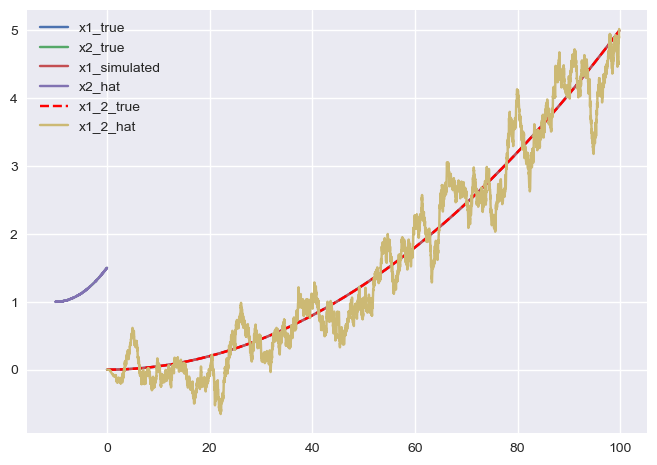

In [15]:
plt.plot(x_true[0,:], x_true[1,:])
plt.plot(x2_true[0,:], x2_true[1,:])
plt.plot(x2_true[3,:], x2_true[4,:])
plt.plot(x2_hat[0,:], x2_hat[1,:])
plt.plot(log[:,0], log[:,1], 'r--')
plt.plot(x2_hat[3,:], x2_hat[4,:])

plt.legend(['x1_true', 'x2_true', 'x1_simulated', 'x2_hat', 'x1_2_true', 'x1_2_hat'])
plt.plot()

In [12]:
x2_hat[3,:]

array([ 0., nan, nan, ..., nan, nan, nan])

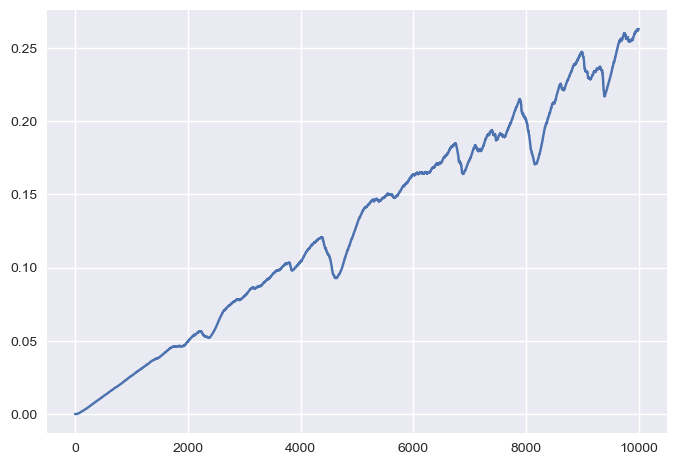

In [293]:
plt.plot(P2[4,4,:])

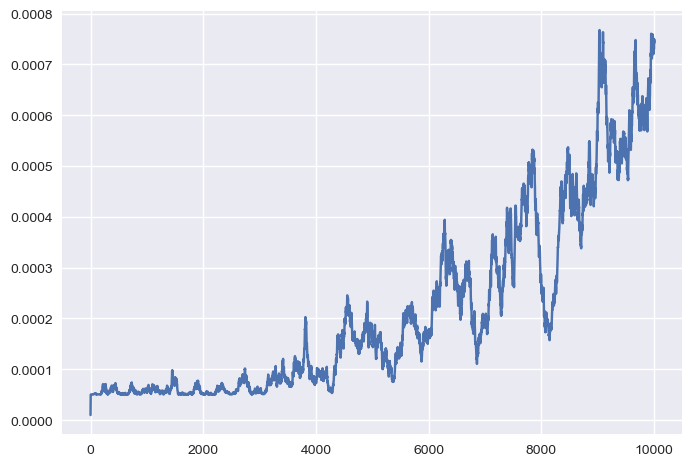

In [294]:
plt.plot(P2[3,3,:])

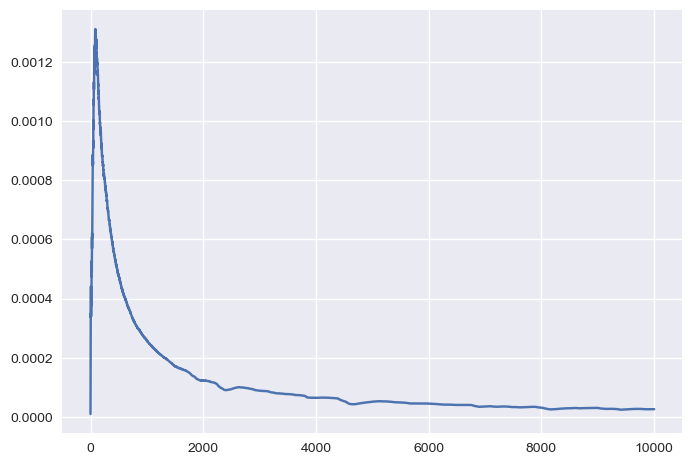

In [296]:
plt.plot(P2[2,2,:])

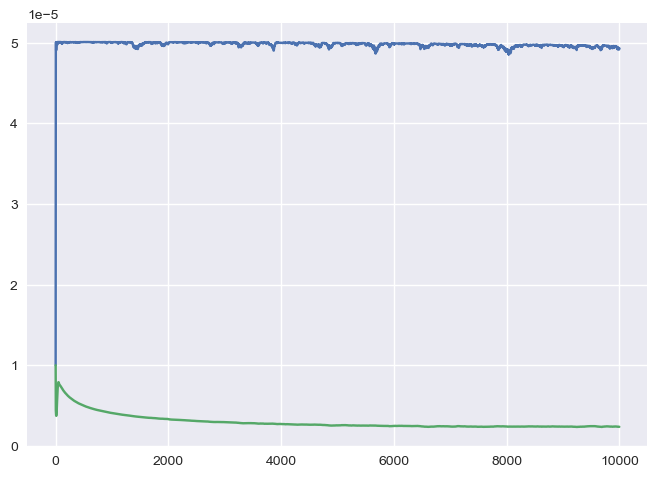

In [255]:
plt.plot(P2[0,0,:])
plt.plot(P2[1,1,:])